# Semantic Segmentation of Satellite Images 

The task here is to segment the satellite images by training a deep neural network and outputting per-pixel mask of the image.  

## Importing Libraries 

In [1]:
import cv2
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from random import randint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D,ReLU, concatenate, BatchNormalization,MaxPooling2D, Dropout,Conv2DTranspose, UpSampling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import plot_model
from osgeo import gdal




### Important parameters to define the training and testing data

In [2]:
n_channels =12
n_train = 400
n_valid = 100
n_test = 30

## Data Preparation

Images are in .tif format. We start by looking at number of bands in the input image and extract only bands 4,3,2 if we want to train model on RGB images else we extract all bands and convert it into an array

In [3]:
def raster2img(img_data):
    bands_count= img_data.RasterCount
    
    if n_channels==3:
        r = img_data.GetRasterBand(4)
        g = img_data.GetRasterBand(3)
        b = img_data.GetRasterBand(2)
        
        r = r.ReadAsArray()
        g = g.ReadAsArray()
        b = b.ReadAsArray()
        
        img = np.dstack((r,g,b))
        out = np.zeros_like(img).astype(np.float32)
        n = img.shape[2]
        for i in range(n):
            a,b = 0,1
            c = np.percentile(img[:,:,i],2)
            d = np.percentile(img[:,:,i],98)
            t = a+(img[:,:,i]-c)*(b-a)/(d-c)
            t[t<a] = a
            t[t>b] = b
            out[:,:,i] = t
    
    elif n_channels==12:
        img = np.zeros([64,64,bands_count])
        out = np.zeros_like(img).astype(np.float32)
        for i in range(bands_count):
            data = img_data.GetRasterBand(1)
            img[:,:,i] = data.ReadAsArray(0,0,img_data.RasterXSize,img_data.RasterYSize)

            a,b = 0,1
            c = np.percentile(img[:,:,i],2)
            d = np.percentile(img[:,:,i],98)
            t = a+(img[:,:,i]-c)*(b-a)/(d-c)
            t[t<a] = a
            t[t>b] = b

            out[:,:,i] = t
        
    return out

Now we want to split the images for training, validation and testing. We split in ratio of 80:20. A function is defined to split the images and the path has to be specified before hand

In [4]:
def images_split(total_images_path,n_train,n_valid,n_test):
    total_images = []
    count = 0
    if count <530:
        count = count + 1 

        for file in glob.iglob(total_images_path+'**/*.tif',recursive=True):
            
            image = gdal.Open(file, gdal.GA_ReadOnly)
            output_image = raster2img(image)
            total_images.append(output_image)
    
    total_images_count = len(total_images)
    total_images = np.asarray(total_images)
    X_train = []
    X_valid = []
    X_test = []

    for i in range(0,n_train):
        X_train.append(total_images[i])

    for i in range(n_train,n_train+n_valid):
        X_valid.append(total_images[i])

    for i in range(n_train+n_valid,n_train+n_valid+n_test):
        X_test.append(total_images[i])
    
    X_train = np.asarray(X_train)
    X_valid = np.asarray(X_valid)
    X_test = np.asarray(X_test)

    return X_train,X_valid,X_test
    

In [5]:
total_images_path= 'D:/vision_impulse/images/'
X_train, X_valid, X_test = images_split(total_images_path,n_train,n_valid,n_test)

Like Images the labels are also in .tif format. But labels are single banded images. So we extract that solo band and convert to image of 1 channel.

In [6]:
def raster2label(img_data):
    bands_count = img_data.RasterCount
    if bands_count ==1:
        gray = img_data.GetRasterBand(1)

        gray1 = gray.ReadAsArray()

        label = np.asarray(gray1)
        
    return label

In [7]:
def labels_split(total_labels_path,n_train,n_valid,n_test):
    total_labels = []
    count = 0
    if count < 530:
        count = count + 1
        for file in glob.iglob(total_labels_path+'**/*.tif',recursive=True):
            label = gdal.Open(file, gdal.GA_ReadOnly)
            g = label.GetRasterBand(1)
            g = label.ReadAsArray()
            g = g.reshape((64,64,1))
        #print(g)        
        #output_label = raster2label(label)

            total_labels.append(g)
    
    total_label_count = len(total_labels)
    total_labels = np.asarray(total_labels)

    y_train = []
    y_valid = []
    y_test = []

    for i in range(0,n_train):
        l = total_labels[i]
        l = tf.keras.utils.to_categorical(l,3)
        y_train.append(l)

    for i in range(n_train,n_train+n_valid):
        l = total_labels[i]
        l = tf.keras.utils.to_categorical(l,3)
        y_valid.append(l)

    for i in range(n_train+n_valid,n_train+n_valid+n_test):
        l = total_labels[i]
        l = tf.keras.utils.to_categorical(l,3)
        y_test.append(l)
    
    y_train = np.asarray(y_train)
    y_valid = np.asarray(y_valid)
    y_test = np.asarray(y_test)

    return y_train,y_valid,y_test


In [8]:
total_labels_path = 'D:/vision_data_duplicate/vision_impulse/labels/'
y_train, y_valid, y_test = labels_split(total_labels_path,n_train,n_valid,n_test)

Just to make sure if the sizes of both images and labels are equal we use assert and check if they are of same size.

In [9]:
assert X_train.shape[0] == y_train.shape[0]
print(f'X_train and y_train are of same length : {X_train.shape[0]}')

X_train and y_train are of same length : 400


Finally we print the shapes and sizes of the images and labels in all the category splits.

In [10]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(400, 64, 64, 12)
(100, 64, 64, 12)
(30, 64, 64, 12)
(400, 64, 64, 3)
(100, 64, 64, 3)
(30, 64, 64, 3)


It is well-known that matplotlib cannot plot a 12 channel image. So, in case of working with 12 channel image, we visualize predicted image label and actual label. If the image is RGB we visualize input image, input label and predicted image.

In [11]:
def visualize(viz_list):

    if n_channels ==3:
        plt.figure(figsize=(15,15))
        title = ['Input_mask', 'predicted_mask']
        for i in range(len(viz_list)):
            plt.subplot(1,len(viz_list), i+1)
            plt.title(title[i])
            plt.imshow(viz_list[i])
            plt.axis('off')
        plt.show()
        
    else:
        plt.figure(figsize=(15,15))
        title = ['input_mask','predicted_mask']
        for i in range(len(viz_list)):
            plt.subplot(1,len(viz_list),i+1)
            plt.title(title[i])
            plt.imshow(viz_list[i])
            plt.axis('off')
        plt.show()
    

## Building Models and picking the model

In coming blocks I built model as a vanilla U-Net model.

Now we are constructing the architecture of DeepLabv3 and we need to make AtrousPyramid Block first.

The model below is normal vanilla U_Net

In [12]:
def U_Net(n_classes=3,im_size=64,n_channels=n_channels,n_filters=32,k_size=3,upconv=True):
    dropout_rate = 0.2
    n_filters = n_filters #32 64x64
    input_lr = Input((im_size,im_size,n_channels))
    conv1 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(input_lr)
    conv1 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv1)
    p1 = MaxPooling2D(pool_size=(2,2))(conv1)
    p1 = Dropout(dropout_rate)(p1)
    p1 = BatchNormalization()(p1)
    
    n_filters *= 2 #64 32x32
    conv2 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p1)
    conv2 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv2)
    p2 = MaxPooling2D(pool_size=(2,2))(conv2)
    p2 = Dropout(dropout_rate)(p2)
    p2 = BatchNormalization()(p2)
    
    n_filters *= 2 #128 16x16
    conv3 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p2)
    conv3 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv3)
    p3 = MaxPooling2D(pool_size=(2,2))(conv3)
    p3 = Dropout(dropout_rate)(p3)
    p3 = BatchNormalization()(p3)
    
    n_filters *= 2 #256 8x8
    conv4 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p3)
    conv4 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv4)
    conv4 = Dropout(dropout_rate)(conv4)
    conv4 = BatchNormalization()(conv4)

    conv4 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv4)
    conv4 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv4)
    p4 = MaxPooling2D(pool_size=(2,2))(conv4)
    p4 = Dropout(dropout_rate)(p4)
    p4 = BatchNormalization()(p4)
    
    n_filters *= 2 #512 4x4
    conv5 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p4)
    conv5 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv5)
    conv5 = Dropout(dropout_rate)(conv5)
    conv5 = BatchNormalization()(conv5)

    conv5 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv5)
    conv5 = Conv2D(filters= n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(conv5)
    p5 = MaxPooling2D(pool_size=(2,2))(conv5)
    p5 = Dropout(dropout_rate)(p5)
    p5 = BatchNormalization()(p5)   
    
    n_filters *= 2 #1024 2x2
    conv6 = Conv2D(filters = n_filters,kernel_size=k_size,padding='same',activation='relu',kernel_initializer='he_normal')(p5)
    conv6 = BatchNormalization()(conv6)
    
    #upsampling block
    
    n_filters //= 2 #512 4x4
    if upconv:
        up5 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv6)
        up5 = concatenate([up5,conv5])
    else:
        up5 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv6)
        up5 = concatenate([up5,conv5])

    up5 = BatchNormalization()(up5)
    conv7 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up5)
    conv7 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv7)
    conv7 = Dropout(dropout_rate)(conv7)
    
    n_filters //= 2 #256 8x8 
    if upconv:
        up4 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv7)
        up4 = concatenate([up4,conv4])
    else:
        up4 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv7)
        up4 = concatenate([up4,conv4])

    up4 = BatchNormalization()(up4)
    conv8 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up4)
    conv8 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv8)
    conv8 = Dropout(dropout_rate)(conv8)
    
    n_filters //= 2  #128 16x16
    if upconv:
        up3 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv8)
        up3 = concatenate([up3,conv3])
    else:
        up3 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv8)
        up3 = concatenate([up3,conv3])

    up3 = BatchNormalization()(up3)
    conv9 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up3)
    conv9 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv9)
    conv9 = Dropout(dropout_rate)(conv9)
    
    n_filters //= 2  #64 32x32
    if upconv:
        up2 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv9)
        up2 = concatenate([up2,conv2])
    else:
        up2 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv9)
        up2 = concatenate([up2,conv2])

    up2 = BatchNormalization()(up2)
    conv10 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up2)
    conv10 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv10)
    conv10 = Dropout(dropout_rate)(conv10)
    
    n_filters //= 2  #32 64x64
    if upconv:
        up1 = Conv2DTranspose(filters=n_filters,kernel_size=k_size,strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(conv10)
        up1 = concatenate([up1,conv1])
    else:
        up1 = UpSampling2D(size=(2,2),interpolation='bilinear')(conv9)
        up1 = concatenate([up1,conv1])

    up1 = BatchNormalization()(up1)
    conv11 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(up1)
    conv11 = Conv2D(filters=n_filters,kernel_size=k_size,padding='same',kernel_initializer='he_normal',activation='relu')(conv11)
    conv11 = Dropout(dropout_rate)(conv11)   
    
    output = Conv2D(filters=n_classes,kernel_size=(1,1),padding='same',kernel_initializer='he_normal',activation='softmax')(conv11)
    
    model = Model(inputs = input_lr, outputs = output)
    
    return model

In [14]:
model = U_Net()

We got the model and we print the statistics on number of total parameters along with count of trainable and non-trainable parameters.

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 12)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   3488        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

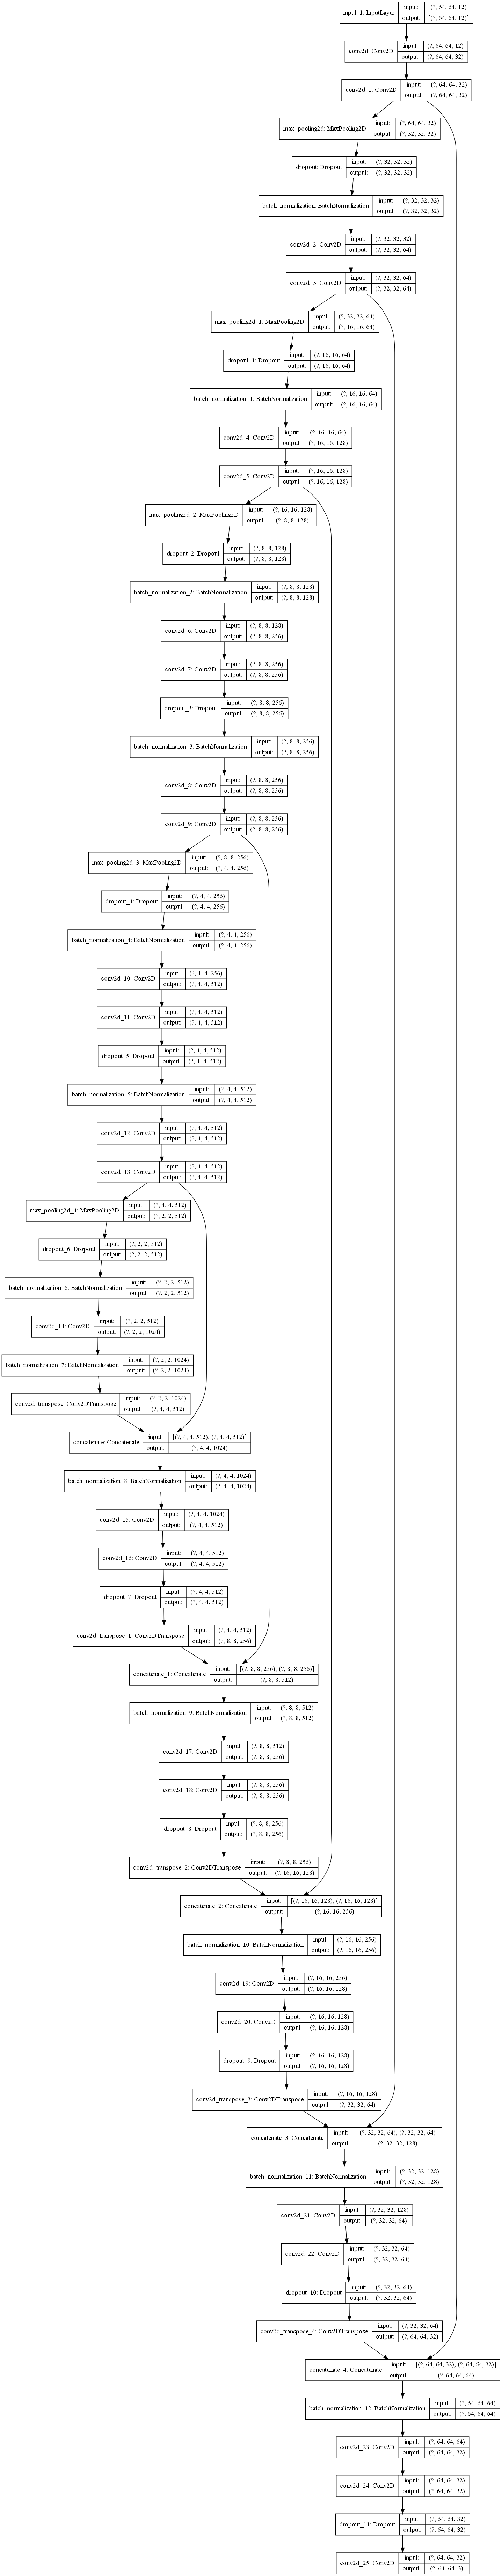

In [16]:
plot_model(model,to_file='D:/vision_impulse/model_'+'multi-spectral'+'.png',show_shapes=True,show_layer_names=True)

Now model needs to be compiled 

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Create callbacks namely early-stopping and modelcheckpoint

In [18]:
weights_path = 'D:/vision_impulse/weights/'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
    
file_path = os.path.join(weights_path+'model')
print(file_path)


D:/vision_impulse/weights/model


In [19]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

es = EarlyStopping(patience=100,monitor='val_loss',mode ='auto',restore_best_weights=True)
mc = ModelCheckpoint(filepath = file_path,monitor='val_loss',save_best_only=True)


### Training Metrics


In [20]:
batch_size= 8
steps_per_epoch = int(len(X_train)//batch_size)
epochs = 200

Start of Training Process

In [21]:
history = model.fit(X_train,y_train,steps_per_epoch = steps_per_epoch,validation_data=(X_valid,y_valid),epochs = epochs,callbacks = [es,mc])

Epoch 1/200
50/50 [==============================] - ETA: 0s - loss: 0.7466 - accuracy: 0.7225WARNING:tensorflow:From C:\Users\Dheeraj Reddy P\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:/vision_impulse/weights/model\assets
50/50 [==============================] - 27s 546ms/step - loss: 0.7466 - accuracy: 0.7225 - val_loss: 6.8520 - val_accuracy: 0.5650
Epoch 2/200
50/50 [==============================] - 18s 360ms/step - loss: 0.5931 - accuracy: 0.7843 - val_loss: 0.6467 - val_accuracy: 0.7454
Epoch 3/200
50/50 [==============================] - 11s 224ms/step - loss: 0.5770 - accuracy: 0.7874 - val_loss: 1.4208 - val_accuracy: 0.3734
Epoch 4/200
50/50 [======

50/50 [==============================] - 11s 223ms/step - loss: 0.3788 - accuracy: 0.8516 - val_loss: 0.8396 - val_accuracy: 0.7042
Epoch 45/200
50/50 [==============================] - 11s 223ms/step - loss: 0.3688 - accuracy: 0.8571 - val_loss: 0.3699 - val_accuracy: 0.8434
Epoch 46/200
50/50 [==============================] - 20s 402ms/step - loss: 0.3562 - accuracy: 0.8616 - val_loss: 0.3524 - val_accuracy: 0.8466
Epoch 47/200
50/50 [==============================] - 11s 224ms/step - loss: 0.3830 - accuracy: 0.8530 - val_loss: 0.4291 - val_accuracy: 0.8278
Epoch 48/200
50/50 [==============================] - 20s 396ms/step - loss: 0.3614 - accuracy: 0.8594 - val_loss: 0.3465 - val_accuracy: 0.8466
Epoch 49/200
50/50 [==============================] - 11s 224ms/step - loss: 0.3817 - accuracy: 0.8558 - val_loss: 0.3859 - val_accuracy: 0.8327
Epoch 50/200
50/50 [==============================] - 11s 224ms/step - loss: 0.3523 - accuracy: 0.8603 - val_loss: 0.3867 - val_accuracy: 0.831

50/50 [==============================] - 11s 223ms/step - loss: 0.2826 - accuracy: 0.8836 - val_loss: 0.4184 - val_accuracy: 0.8395
Epoch 99/200
50/50 [==============================] - 11s 224ms/step - loss: 0.2935 - accuracy: 0.8790 - val_loss: 0.4621 - val_accuracy: 0.8248
Epoch 100/200
50/50 [==============================] - 11s 224ms/step - loss: 0.3022 - accuracy: 0.8762 - val_loss: 0.4085 - val_accuracy: 0.8412
Epoch 101/200
50/50 [==============================] - 11s 223ms/step - loss: 0.2808 - accuracy: 0.8836 - val_loss: 0.3878 - val_accuracy: 0.8445
Epoch 102/200
50/50 [==============================] - 11s 223ms/step - loss: 0.2745 - accuracy: 0.8852 - val_loss: 0.4069 - val_accuracy: 0.8402
Epoch 103/200
50/50 [==============================] - 11s 223ms/step - loss: 0.2712 - accuracy: 0.8850 - val_loss: 0.3685 - val_accuracy: 0.8460
Epoch 104/200
50/50 [==============================] - 11s 223ms/step - loss: 0.2747 - accuracy: 0.8852 - val_loss: 0.4636 - val_accuracy: 

Save the trained model weights 

In [22]:
model.save('D:/vision_impulse/weights/mymodel_multi_spectral.h5')

The final step make predictions and visualize

In [23]:
y_pred =model.predict(X_test)

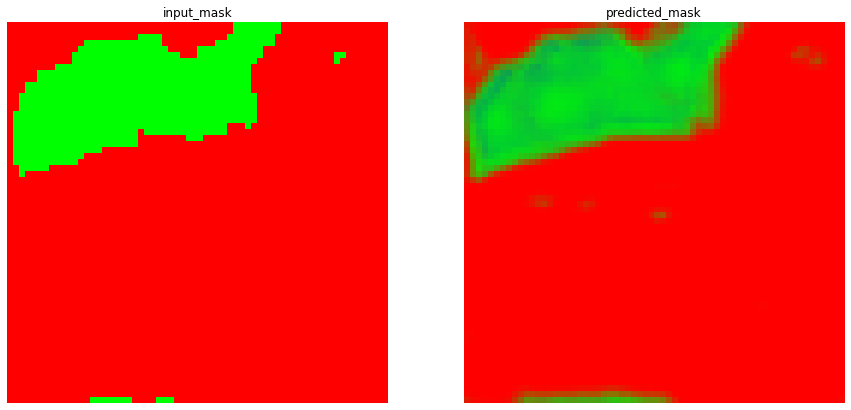

In [27]:
visualize([y_test[12],y_pred[12]])